In [23]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
import math


DATAPATH = 'data'

dateparse = lambda x: pd.datetime.strptime(x, '%d/%m/%y %H')

data3 = pd.read_csv(os.path.join(DATAPATH, 'BATADAL_dataset03.csv'), index_col=0, 
parse_dates=[0], date_parser=dateparse)
data4 = pd.read_csv(os.path.join(DATAPATH, 'BATADAL_dataset04-lab.csv'), index_col=0, parse_dates=[0], date_parser=dateparse, dtype={':L_T1':float})
data_test = pd.read_csv(os.path.join(DATAPATH, 'BATADAL_test_dataset.csv'), index_col=0, parse_dates=[0], date_parser=dateparse)

# for k, v in enumerate(data4.columns):
#     print("{} - {}".format(k, v))
# data4 and data_test seem to have spaces before the labels....
data4.columns = data3.columns
data_test.columns = data3.columns[:len(data3.columns)-1]

# Separate labels, test dataset has no labels
data3_labels = data3['ATT_FLAG']
data4_labels = data4['ATT_FLAG']
data3.drop(columns=['ATT_FLAG'], inplace=True)
data4.drop(columns=['ATT_FLAG'], inplace=True)

# Helper functions
def getDate(df):
    return df['DATETIME']

# 1 to 7
def getTankLevel(df, tank_id):
    assert tank_id >= 1 and tank_id <= 7, 'Invalid tank id, must be between 1 and 7'
    return df['L_T{}'.format(tank_id)]

# 1 to 11
def getPumpInfo(df, pump_id):
    assert pump_id >= 1 and pump_id <= 11, 'Invalid pump id, must be between 1 and 11'
    return df[['F_PU{}'.format(pump_id), + 'S_PU{}'.format(pump_id)]]

# Only valve 2
def getValve(df):
    return df[['F_V2', 'S_V2']]

# Pressure levels, 1 to 12
def getPressure(df, junction_id):
    assert junction_id >= 1 and junction_id <= 12, 'Invalid junction id, must be between 1 and 12'
    return df[df.columns[32+junction_id:32+junction_id+1]]

def getAttackFlag(df):
    return df[['ATT_FLAG']]

def timerseries_test_train_split(data, split):
    split_Nr = int(len(data) * split)
    train = data.iloc[:-split_Nr]
    test = data.iloc[-split_Nr:]
    return train, test


/home/wouter/.local/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)
/home/wouter/.local/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:191: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  start=index[0], end=index[-1], freq=freq)
/home/wouter/.local/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:320: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  freq=base_index.freq)


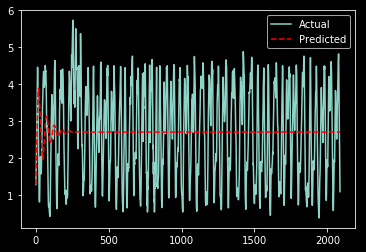

In [24]:
###################################
# Basic prediction
###################################

from statsmodels.tsa.ar_model import AR

data = data4

train, test = timerseries_test_train_split(getTankLevel(data, 1), 0.5)

model = AR(train).fit()
yhat = model.predict(len(train), len(train) + len(test))

plt.plot(test.to_numpy(), label='Actual')
plt.plot(yhat.to_numpy(), 'r--', label='Predicted')
plt.legend()
plt.show()



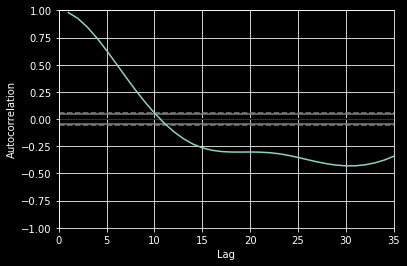

In [25]:
############################################
# Train ARMA model and predict
############################################
# Select Data and evaluate parameters 

from statsmodels.tsa.arima_model import ARMA
from pandas.plotting import autocorrelation_plot

 # Data sensors accordingly between L_T1 - L_T5
data = getTankLevel(data4, 1)
train, test = timerseries_test_train_split(data, 0.5)

ax = autocorrelation_plot(train)
ax.set_xlim([0, 35])

# we update order=(p,q) accordingly. q=1 for all.
# For L_T1: p=10, L_T2: p=6, L_T3 and LT_4: p=4, L_T5: p=3.
model = ARMA(train.values, order=(10, 1)).fit()
predictions = model.forecast(steps=len(test))[0]

##### Few steps at a time, but super slow
# print(len(test))
# history = [x for x in train]
# predictions = list()
# t = 0
# # for t in range(len(test)):
# while t < len(test)-5:
#     model = ARMA(history, order=(10,1))
#     model_fit = model.fit(disp=0)
#     output = model_fit.forecast(steps=5)
#     print(output)
#     yhat = output[0]
#     predictions.append(yhat)
#     obs = np.array(test)[t:t+5]
#     for x in yhat:
#         history.append(x)
#     # history.append(yhat)
#     print('predicted={}, expected={}'.format(yhat, obs))
#     print(t)
#     t = t+5



In [26]:
# Compute the performance of the prediction
x = pd.DataFrame(data = predictions, index = test.index.values[0:len(predictions)])
x.index.name = test.index.name
result = pd.concat([test, x], axis=1)
result.columns = ['Expected', 'Predictions']

result['diff'] = result['Expected'] - result['Predictions']


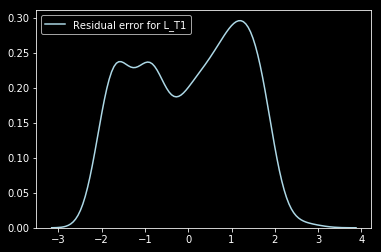

In [27]:
sns.distplot(result['diff'].values, hist=False, kde=True, 
             bins=int(180/5), color = 'lightblue',
             hist_kws={'edgecolor':'black'}, label='Residual error for L_T1')


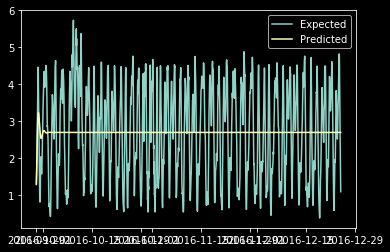

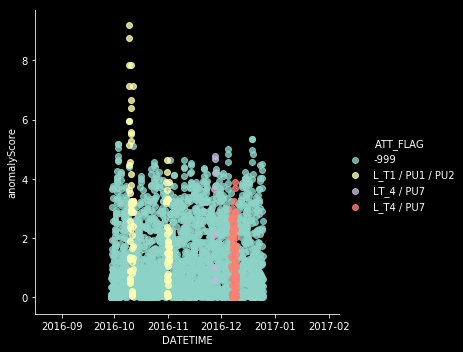

In [28]:

# Plotting expected and predicted values from ARMA
plt.plot(result['Expected'], label='Expected')
plt.plot(result['Predictions'], label='Predicted')
plt.legend()
plt.show()

anomalyARMA = result.merge(data4_labels, left_on="DATETIME", right_on="DATETIME")

anomalyARMA['anomalyScore'] = anomalyARMA["diff"]**2
sns_plot = sns.lmplot(x='DATETIME', y='anomalyScore', hue='ATT_FLAG', data=anomalyARMA.reset_index(), fit_reg=False)
plt.savefig('ARMA_anomaly.png')




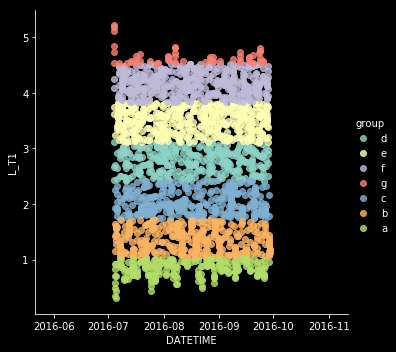

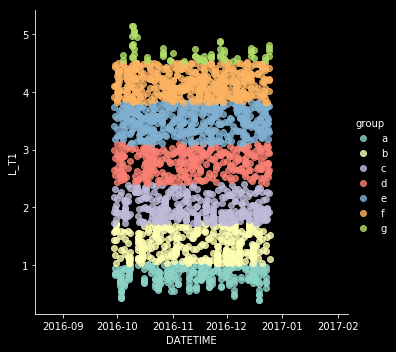

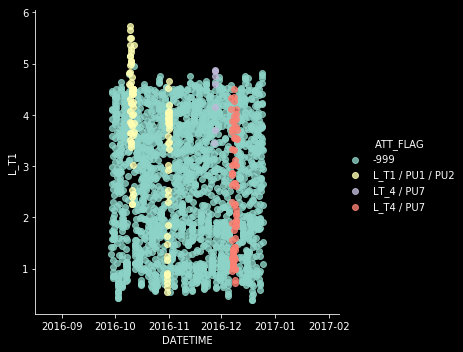

In [29]:
########################################3
# Discretize data
#########################################

dataDisc = getTankLevel(data4, 1)

dataDisc_train, dataDisc_test = timerseries_test_train_split(dataDisc, 0.5)

# "train"
labels = ['a', 'b', 'c', 'd', 'e', 'f', 'g']
groups, bins = pd.cut(np.array(dataDisc_train).ravel(), 7, labels=labels, retbins=True)

dataDisc_train = pd.concat([dataDisc_train.reset_index(), pd.DataFrame(groups)], axis=1)
dataDisc_train.rename(columns = {0:'group'}, inplace=True)

dataDisc_train = dataDisc_train.merge(data4_labels, left_on='DATETIME', right_on='DATETIME')

sns_plot = sns.lmplot(x='DATETIME', y='L_T1', hue='group', data=dataDisc_train.reset_index(), fit_reg=False)
plt.savefig('discretization-train-group.png')


# apply to test set
dataDisc_test = dataDisc_test.to_frame()

dataDisc_test['group'] = pd.cut(dataDisc_test['L_T1'], bins, labels=labels)
dataDisc_test = dataDisc_test.merge(data4_labels, left_on='DATETIME', right_on='DATETIME')

sns_plot = sns.lmplot(x='DATETIME', y='L_T1', hue='group', data=dataDisc_test.reset_index(), fit_reg=False)
plt.savefig('discretization-test-group.png')
sns_plot = sns.lmplot(x='DATETIME', y='L_T1', hue='ATT_FLAG', data=dataDisc_test.reset_index(), fit_reg=False)
plt.savefig('discretization-train-label.png')




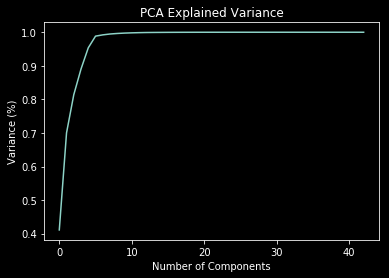

In [30]:
#######################################
# PCA anomaly detection
#######################################

from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve, average_precision_score, roc_curve, auc
import numpy as np


X_train, X_test = timerseries_test_train_split(data4, 0.2)

## Evaluate the amount of PCA features to use
pca = PCA()
pca.fit(X_train)
#Plotting the Cumulative Summation of the Explained Variance
plt.figure()
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)') #for each component
plt.title('PCA Explained Variance')
plt.savefig('nr-of-pca.png', dpi=100)
plt.show()

# Use previously computed settings for anomaly detection
n_components = 6
whiten = False
random_state = 2019

pca = PCA(n_components=n_components, whiten=whiten, 
          random_state=random_state)
X_train_PCA = pca.fit_transform(X_train)
X_train_PCA = pd.DataFrame(data=X_train_PCA, index=X_train.index)

X_train_PCA_inverse = pca.inverse_transform(X_train_PCA)
X_train_PCA_inverse = pd.DataFrame(data=X_train_PCA_inverse, 
                                   index=X_train.index)



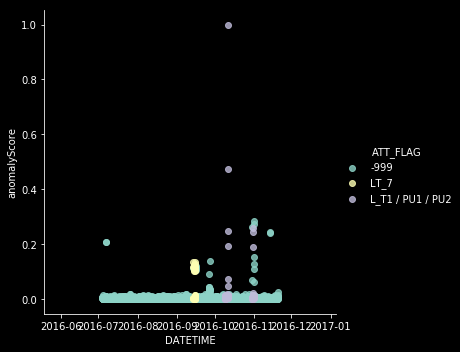

In [31]:
# Anomaly score by distance squared
anomalyScoresPCA = np.sum((np.array(X_train)-np.array(X_train_PCA_inverse))**2, axis=1)
anomalyScoresPCA = pd.Series(data=anomalyScoresPCA,index=X_train.index)
anomalyScoresPCA = (anomalyScoresPCA-np.min(anomalyScoresPCA))/(np.max(anomalyScoresPCA)-np.min(anomalyScoresPCA))

# anomalyScoresPCA.columns
anomalyScoresPCA = pd.concat([anomalyScoresPCA, data4_labels], axis=1, join='inner')

anomalyScoresPCA.rename(columns = {0:'anomalyScore'}, inplace=True)

anomalyScoresPCA.reset_index(inplace=True)
sns_plot = sns.lmplot(x='DATETIME', y='anomalyScore', hue='ATT_FLAG', data=anomalyScoresPCA, fit_reg=False)
plt.savefig('pca_distance.png')







In [32]:
######################
# Comparison
######################

attack = 'L_T1 / PU1 / PU2'
# ARMA
print(anomalyARMA.columns)
armaDecision = 5
TP = anomalyARMA.loc[(anomalyARMA['ATT_FLAG'] == attack) & (anomalyARMA['anomalyScore'] > armaDecision)]
FP = anomalyARMA.loc[(anomalyARMA['ATT_FLAG']!= attack) & (anomalyARMA['anomalyScore'] > armaDecision)]
TN = anomalyARMA.loc[(anomalyARMA['ATT_FLAG']!= attack) & (anomalyARMA['anomalyScore'] <= armaDecision)]
FN = anomalyARMA.loc[(anomalyARMA['ATT_FLAG']!= attack) & (anomalyARMA['anomalyScore'] <= armaDecision)]

ArmaPrecision = len(TP.index) / ( len(TP.index) + len(FP.index))
ArmaRecall = len(TP.index) / ( len(TP.index) + len(FN.index))

print(ArmaPrecision, ArmaRecall)


# Discretized
TP = dataDisc_test.loc[(dataDisc_test['ATT_FLAG'] == attack) & (dataDisc_test['group'] == 'g')]
FP = dataDisc_test.loc[(dataDisc_test['ATT_FLAG'] != attack) & (dataDisc_test['group'] == 'g')]
TN = dataDisc_test.loc[(dataDisc_test['ATT_FLAG'] != attack) & (dataDisc_test['group'] != 'g')]
FN = dataDisc_test.loc[(dataDisc_test['ATT_FLAG'] == attack) & (dataDisc_test['group'] != 'g')]

DiscPrecision = len(TP.index) / ( len(TP.index) + len(FP.index))
DiscRecall = len(TP.index) / ( len(TP.index) + len(FN.index))

print(DiscPrecision, DiscRecall)


# PCA
pcaDecision = 0.2
TP = anomalyScoresPCA.loc[(anomalyScoresPCA['ATT_FLAG'] == attack) & (anomalyScoresPCA['anomalyScore'] > pcaDecision)]
FP = anomalyScoresPCA.loc[(anomalyScoresPCA['ATT_FLAG']!= attack) & (anomalyScoresPCA['anomalyScore'] > pcaDecision)]
TN = anomalyScoresPCA.loc[(anomalyScoresPCA['ATT_FLAG']!= attack) & (anomalyScoresPCA['anomalyScore'] <= pcaDecision)]
FN = anomalyScoresPCA.loc[(anomalyScoresPCA['ATT_FLAG']!= attack) & (anomalyScoresPCA['anomalyScore'] <= pcaDecision)]

PCAprecision = len(TP.index) / ( len(TP.index) + len(FP.index))
PCArecall = len(TP.index) / ( len(TP.index) + len(FN.index))

print(PCAprecision, PCArecall)



Index(['Expected', 'Predictions', 'diff', 'ATT_FLAG', 'anomalyScore'], dtype='object')
0.6666666666666666 0.007007007007007007
0.20967741935483872 0.13402061855670103
0.4166666666666667 0.001541782300339192


In [33]:
######################
##### Bonus: PyTorch
######################
# Define Pytorch long short term memory network

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

class LSTM(nn.Module):

    def __init__(self, input_dim, hidden_dim, batch_size, output_dim=1,
                    num_layers=2):
        super(LSTM, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.batch_size = batch_size
        self.num_layers = num_layers

        # LSTM layer
        self.lstm = nn.LSTM(self.input_dim, self.hidden_dim, self.num_layers)
        # Output layer
        self.linear = nn.Linear(self.hidden_dim, output_dim)
        # Loss function
        self.loss_fn = nn.MSELoss()

    # Initial hidden states
    def init_hidden(self):
        return (torch.zeros(self.num_layers, self.batch_size, self.hidden_dim),
                torch.zeros(self.num_layers, self.batch_size, self.hidden_dim))

    # Forward pass and return the prediction (single step only)
    def forward(self, input):
        lstm_out, self.hidden = self.lstm(input.view(len(input), self.batch_size, -1))
        # prediction
        y_pred = self.linear(lstm_out[-1].view(self.batch_size, -1))
        return y_pred.view(-1)

    # Compute loss
    def loss(self, pred, truth):
        return self.loss_fn(pred, truth)



# Define and train model

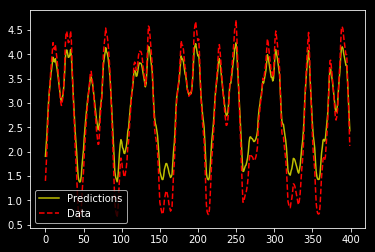

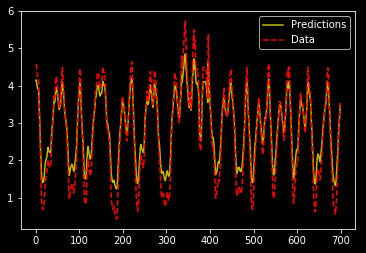

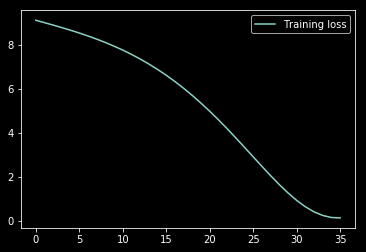

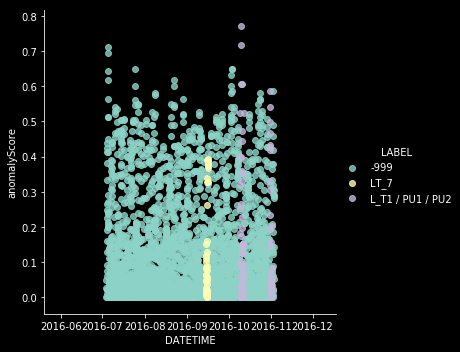

In [34]:
# Data split
test_size = 0.3
torch_data = getTankLevel(data4, 1)
X_train, X_test = y_train, y_test = timerseries_test_train_split(torch_data, test_size)


# Transform data for pandas
X_train = torch.from_numpy(X_train.values).type(torch.Tensor).view([1, -1, 1])
X_test = torch.from_numpy(X_test.values).type(torch.Tensor).view([1, -1, 1])
y_train = torch.from_numpy(y_train.values).type(torch.Tensor).view(-1)
y_test = torch.from_numpy(y_test.values).type(torch.Tensor).view(-1)


# Define model and optimiser
model = LSTM(input_dim=1, hidden_dim=200, batch_size=math.ceil((1-test_size)*len(torch_data)), output_dim=1, num_layers=2)
training_epochs = 36
optimiser = torch.optim.Adam(model.parameters(), lr=0.001)

# set training mode
model.train()
# run epochs
hist = np.zeros(training_epochs)
for t in range(training_epochs):
    # Clear stored gradient
    model.zero_grad()
    
    # Initialise hidden state
    # Don't do this if you want your LSTM to be stateful
    model.hidden = model.init_hidden()
    
    # Forward pass
    y_pred = model.forward(X_train)

    # Compute loss
    loss = model.loss(y_pred, y_train)
    hist[t] = loss.item()

    # Zero out gradient between steps
    optimiser.zero_grad()
    # Backward pass
    loss.backward()
    # Update parameters
    optimiser.step()


# Plots and performance

plt.plot(y_pred.detach().numpy()[100:500], 'y', label='Predictions')
plt.plot(y_train.detach().numpy()[100:500], 'r--', label='Data')
plt.legend()
plt.savefig('torch_regular_fit.png')
plt.show()

plt.plot(y_pred.detach().numpy()[2000:2700], 'y', label='Predictions')
plt.plot(y_train.detach().numpy()[2000:2700], 'r--', label='Data')
plt.legend()
plt.savefig('torch_anomaly_fit.png')
plt.show()

plt.plot(hist, label='Training loss')
plt.legend()
plt.savefig('torch_loss.png')
plt.show()

torch_res = pd.DataFrame({'PREDICTIONS': y_pred.detach().numpy(), 'ACTUAL': y_train.detach().numpy(), 'LABEL': data4_labels.iloc[:len(y_pred)]})


torch_res['anomalyScore'] = (torch_res['ACTUAL'] - torch_res['PREDICTIONS'])**2
torch_res.head()
torch_plot = sns.lmplot(x='DATETIME', y='anomalyScore', hue='LABEL', data=torch_res.reset_index(), fit_reg=False)
plt.savefig('torch_anomaly_score.png')


In [35]:
# Performance
pcaDecision = 0.7
TP = torch_res.loc[(torch_res['LABEL'] == attack) & (torch_res['anomalyScore'] > pcaDecision)]
FP = torch_res.loc[(torch_res['LABEL']!= attack) & (torch_res['anomalyScore'] > pcaDecision)]
TN = torch_res.loc[(torch_res['LABEL']!= attack) & (torch_res['anomalyScore'] <= pcaDecision)]
FN = torch_res.loc[(torch_res['LABEL']!= attack) & (torch_res['anomalyScore'] <= pcaDecision)]

TORCHprecision = len(TP.index) / ( len(TP.index) + len(FP.index))
TORCHrecall = len(TP.index) / ( len(TP.index) + len(FN.index))

print(TORCHprecision, TORCHrecall)


0.6666666666666666 0.0007072135785007072
